### Plot IDM results using the DataFrame stored in IDMResults.pcl 

In [2]:
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
pd.options.mode.chained_assignment = None #Disable copy warnings

In [3]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('IDMResults.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

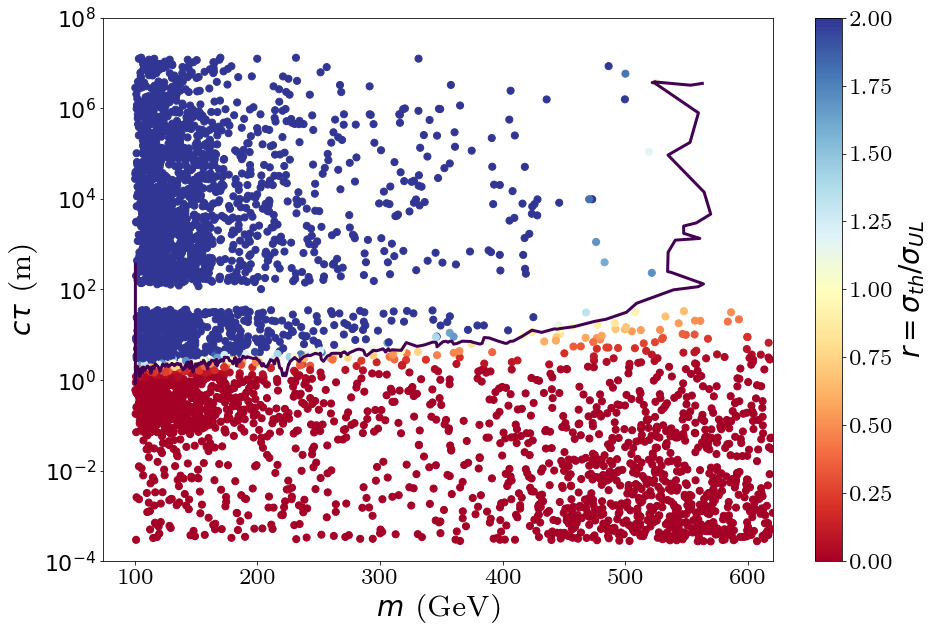

In [4]:
mHc = dataDF['mass.37']
ctau = 1.967e-16/dataDF['width.37']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mHc,ctau,r
# # Plot scatter plot (for double checking the results)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
cs = plt.tricontour(x,y,z,levels=[1.],linewidths=3)
# curve = cs.collections[0].get_paths()[0].vertices
# ysmooth =  savgol_filter(curve[:,1],window_length=11, polyorder=3,mode='interp') # window size 51, polynomial order 3
# plt.plot(curve[:,0],ysmooth,'--')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-4,1e8)
# plt.xlim(80,300)
plt.savefig('IDM_points_r.png')
plt.show()

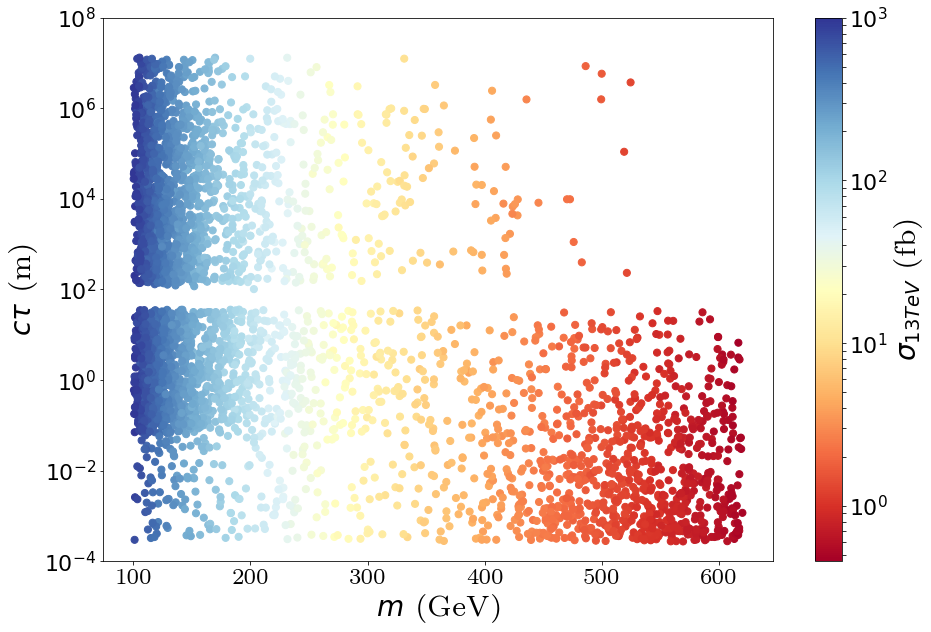

In [6]:
xsec13 = dataDF['totalxsec13TeV(fb)']
x,y,z = mHc,ctau,xsec13
# # Plot scatter plot (for double checking the results)
cp = plt.scatter(x,y, c=z, vmin=z.min(), vmax=z.max(), s=50, cmap=cm, norm=LogNorm())
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$\sigma_{13TeV}$ (fb)')
plt.ylim(1e-4,1e8)
plt.show()

In [7]:
sel = dataDF[(dataDF['mass.37']>520.) & (dataDF['ExptRes.result0.r']>1.)]
print(sel.index.tolist()[0])
for col in sel:
    print(col,sel.iloc[0][col])

20000000291_paramcard.slha
mass.35 521.444132938
mass.36 524.5458888
mass.37 521.53376415
width.35 0.0
width.36 4.428998e-10
width.37 8.4816e-19
xsec13TeV(fb).-37_35 0.12418
xsec13TeV(fb).-37_36 0.12168999999999999
xsec13TeV(fb).-37_37 0.25880000000000003
xsec13TeV(fb).35_35 2.4563e-09
xsec13TeV(fb).35_36 0.2318
xsec13TeV(fb).35_37 0.31753
xsec13TeV(fb).36_36 1.8789e-05
xsec13TeV(fb).36_37 0.32288
xsec8TeV(fb).-37_35 0.024981999999999997
xsec8TeV(fb).-37_36 0.024359
xsec8TeV(fb).-37_37 0.055754000000000005
xsec8TeV(fb).35_35 3.4864e-10
xsec8TeV(fb).35_36 0.049457
xsec8TeV(fb).35_37 0.073347
xsec8TeV(fb).36_36 2.7064e-06
xsec8TeV(fb).36_37 0.073835
totalxsec13TeV(fb) 1.3768987914563
totalxsec8TeV(fb) 0.30173670674864
ExptRes.result0.AnalysisID CMS-PAS-EXO-16-036
ExptRes.result0.AnalysisSqrts (TeV) 13.0
ExptRes.result0.DataSetID c300
ExptRes.result0.Mass (GeV) None
ExptRes.result0.TxNames ['THSCPM1b', 'THSCPM2b']
ExptRes.result0.chi2 23.842928046791513
ExptRes.result0.dataType efficiency

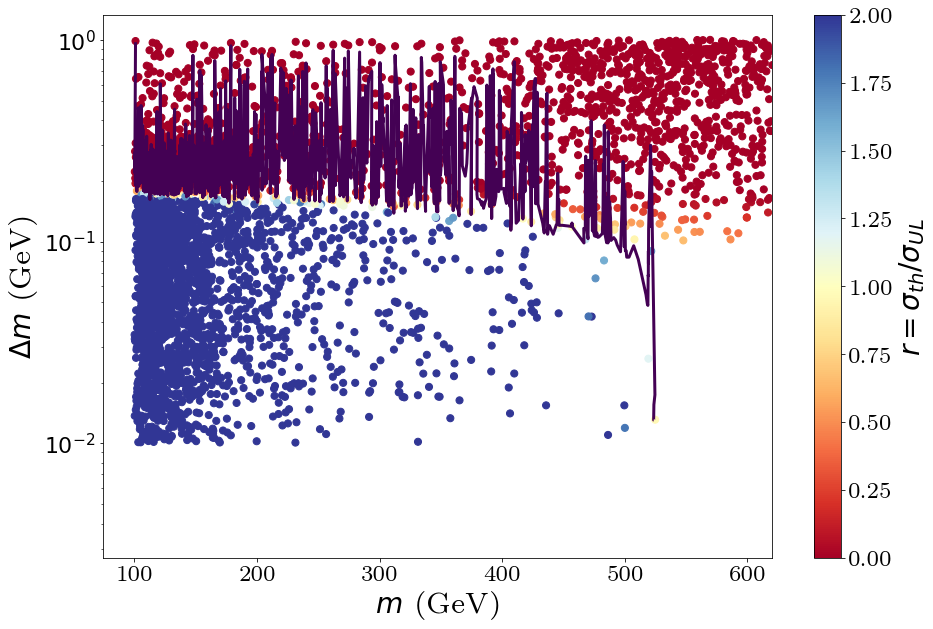

In [8]:
deltaM = (dataDF['mass.37']-dataDF['mass.35'])
mHc = dataDF['mass.37']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mHc,deltaM,r
# # Plot scatter plot (for double checking the results)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
cs = plt.tricontour(x,y,z,levels=[1.],linewidths=3)
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$\Delta m$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
# plt.ylim(1e-4,1e8)
# plt.xlim(80,300)
plt.savefig('IDM_points_deltaM.png')
plt.show()

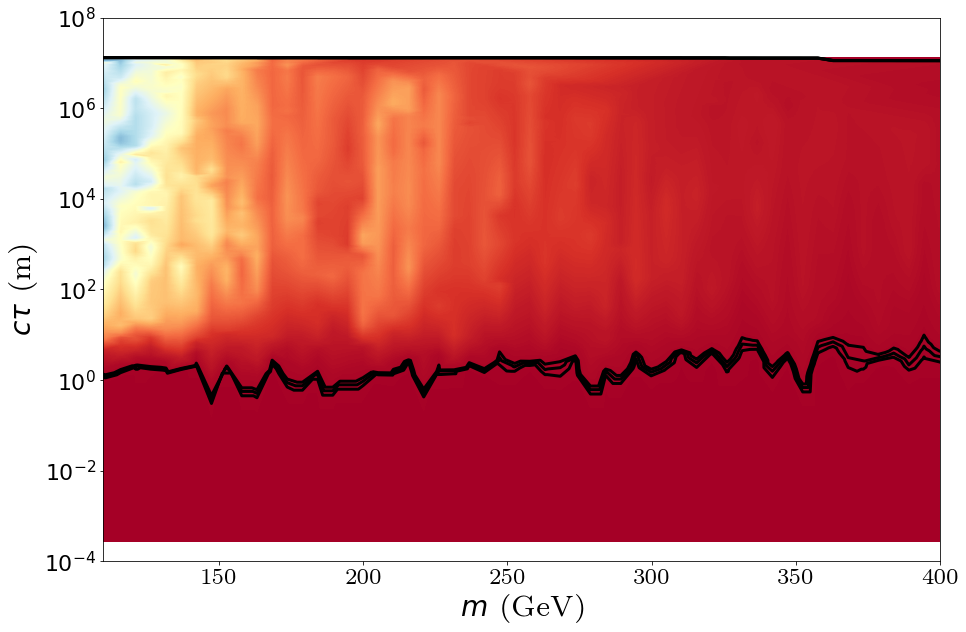

In [74]:
from scipy.interpolate import griddata
x,y,z = mHc,ctau,r

#Create a regular grid and interpolate using the original data:
newX = np.linspace(x.min(),x.max(),100)
newLogY = np.linspace(np.log10(y.min()),np.log10(y.max()),200)
newX, newLogY = np.meshgrid(newX,newLogY)

#Interpolate in log-scale:
oldLogPoints = np.array(list(zip(x,np.log10(y))))
newLogPoints = np.array([newX.flatten(),newLogY.flatten()]).T
newZ = griddata(oldLogPoints,z,newLogPoints,method='linear',fill_value=0.)

# Create the Triangulation; no triangles so Delaunay triangulation created.
newX = newLogPoints[:,0]
newY = np.power(10,newLogPoints[:,1])
triang = tri.Triangulation(newX,newY)
cp = plt.tricontourf(triang, newZ,cmap=cm, levels=np.arange(0.,120.,0.2))
cs = plt.tricontour(triang, newZ, colors='k',levels=[0.8,1.0,1.2])
# # plt.clabel(cs, cs.levels, inline=True, fontsize=25, fmt='%1.1f')
# # cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
# # cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-4,1e8)
plt.xlim(110.,400.)
# # # plt.savefig('gbPlot.pdf')
plt.show()
